In [1]:
from tensorflow.keras.models import Sequential

C:\ana\envs\ReinforcementLearningOldVersion\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ana\envs\ReinforcementLearningOldVersion\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ana\envs\ReinforcementLearningOldVersion\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ana\envs\ReinforcementLearningOldVersion\lib\s

In [35]:
import gym
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from plan_experiments import experiment_params
from matplotlib import pyplot as plt

In [36]:
# Abrindo imagens
env = gym.make('Pong-v0')

state = env.reset()

In [37]:
def show_image(state):
    %pylab inline
    import matplotlib.pyplot as plt
    plt.axis("off")
    imgplot = plt.imshow(state)
    plt.show()

In [38]:
%%time

def to_gray_scale(state):
    return 0.299*state[:,:,0] + 0.587*state[:,:,1] + 0.114*state[:,:,2]

Wall time: 0 ns


In [39]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [40]:
crop_on_top                =              35
crop_on_bottom             =              16
crop_on_left               =              7
crop_on_right              =              7

def crop_img(img):
        #return img[self.crop_on_top: -self.crop_on_bottom, self.crop_on_border:-self.crop_on_border]
        return img[crop_on_top:-crop_on_bottom, crop_on_left:-crop_on_right]

In [41]:
whos

Variable                 Type         Data/Info
-----------------------------------------------
Adam                     type         <class 'keras.optimizers.Adam'>
Conv2D                   type         <class 'keras.layers.convolutional.Conv2D'>
Dense                    type         <class 'keras.layers.core.Dense'>
Flatten                  type         <class 'keras.layers.core.Flatten'>
MaxPooling2D             type         <class 'keras.layers.pooling.MaxPooling2D'>
Sequential               type         <class 'keras.engine.sequential.Sequential'>
build_model              function     <function build_model at 0x0000011ACB7C80D0>
crop_img                 function     <function crop_img at 0x0000011ACC9EB400>
crop_on_bottom           int          16
crop_on_left             int          7
crop_on_right            int          7
crop_on_top              int          35
cv2                      module       <module 'cv2' from 'C:\\a<...>kages\\cv2\\__init__.py'>
deque                 

## Testando duas maneiras de pré-processamento de imagem

In [42]:
# WORST WAY

def preprocess_img(img):        
        return to_gray_scale(cv2.resize(crop_img(img), (80,80), interpolation=cv2.INTER_AREA)) / 255

In [43]:
## BEST WAY !!!

def preprocess_img_with_cv(img):
    return np.divide(cv2.cvtColor(cv2.resize(crop_img(state) , (80,80), interpolation=cv2.INTER_AREA), cv2.COLOR_RGB2GRAY ), 255)

In [44]:
grayscale_old = preprocess_img(state)
grayscale_new = preprocess_img_with_cv(state)

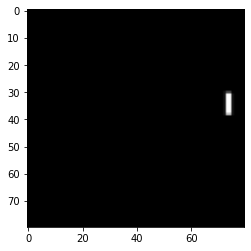

In [45]:
plt.imshow(grayscale_new, cmap='gray')

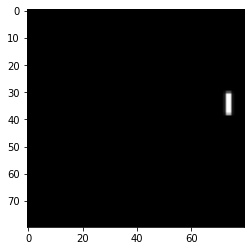

In [46]:
plt.imshow(grayscale_old, cmap='gray')

In [47]:
%%time

# Testando a maneira que estamos aplicando a IC.

for i in range(10000):
    grayscale = preprocess_img(state)

Wall time: 2.54 s


In [48]:
%%time
for i in range(10000):
    grayscale = preprocess_img_with_cv(state)

Wall time: 2.18 s


## Tentativa de otimização no processo de treinamento da rede neural.

In [49]:
## Importações necessárias
import random
import tensorflow as tf
from plan_experiments import experiment_params
import time

In [50]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

AttributeError: module 'tensorflow' has no attribute 'config'

In [51]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)

'''
 ' Same as above but returns the mean loss.
'''
def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def build_model():
        
        # Neural Net for Deep-Q learning Model
        model = Sequential()


        ## Create structure of convolucional network.
        structure_convolucional = experiment_params['structure_neural_network']['conv']

        for conv in structure_convolucional:
            model.add(Conv2D(conv['filter'], conv['kernel_size'], strides=conv['strides'],  input_shape = (80, 80, 4),
                             activation=conv['activation'], padding=conv['padding']))

        model.add(Flatten()) # Transform image resulting of convolution to 1 dimension

        ## Create structure of neural network.
        structure_nn = experiment_params['structure_neural_network']['neural_network']

        for nn in structure_nn:
            k_init = nn['kernel_initializer'] if 'kernel_initializer' in nn else 'glorot_uniform'
            model.add(Dense(nn['neurons'], activation=nn['activation'], kernel_initializer=k_init))

        model.add(Dense(4, activation='linear'))
        model.compile(loss=huber_loss_mean, optimizer=Adam(lr=.0001))

        model.summary()
        return model

In [52]:
    def pack_K_frames(sample_batch_size):
        
        state = np.empty((sample_batch_size, 4, 80, 80))
        action = np.empty(sample_batch_size, dtype=np.uint8)
        reward = np.empty(sample_batch_size, dtype=np.float32)
        next_state = np.empty((sample_batch_size, 4, 80, 80))
        done = np.empty(sample_batch_size, dtype=bool)
        

        for k in range(sample_batch_size):
            index = random.randint(0, len(memory)-4-2)
            
            for i, idx_memory in enumerate(range(index, index+4)):
                s, a, r, n_s, d = memory[idx_memory]
            
                state[k][i] = s
                next_state[k][i] = n_s
                
            done[k] = d
            action[k] = a
            reward[k] = r
            
        #State = (32,4,84,84)  -> State Transpose = (32,84,84,4) 
        return np.transpose(state, axes=(0,2,3,1)), action, reward, np.transpose(next_state, axes=(0,2,3,1)), done

In [53]:
 def replay(sample_batch_size):
    
    soma = 0
    t = time.time()
    #sample_batch = random.sample(self.memory, sample_batch_size)
    state, action, reward, next_state, done = pack_K_frames(sample_batch_size)
    time_pack_K_frames = time.time() - t
    t = time.time()
    
    t = time.time()
    with tf.device('/gpu:0'):
        predicted = brain_target.predict(next_state) #Previsão proximo estado.
    time_predicted = time.time() - t
    t = time.time()
    with tf.device('/gpu:0'):
        target_f = brain.predict(state) #Previsão estado atual.
    time_target_f = time.time() - t
    t = time.time()
        
    for i in range(sample_batch_size):
        target = reward[i] + (.99 * np.amax(predicted[i]) * (1-done[i]))
        target_f[i][action[i]] = target
    
    time_calc = time.time() - t
    t = time.time()
    
    with tf.device('/gpu:0'):
        brain.fit(state, target_f, batch_size=sample_batch_size, epochs=1, verbose=0, shuffle=False)
    time_fit = time.time() - t
    
    soma = (time_predicted + time_calc + time_fit + time_target_f + time_pack_K_frames)
    time_predicted = (time_predicted / soma)*100
    time_target_f = (time_target_f / soma)*100
    time_calc = (time_calc / soma)*100
    time_fit = (time_fit / soma)*100
    time_pack_K_frames = (time_pack_K_frames / soma)*100
    
#     print('K_frames: {}\nPredicted: {}\nTarget_F: {}\nCalc: {}\nFit: {}'.format(time_pack_K_frames, 
#                                                                                 time_predicted, 
#                                                                                 time_target_f, 
#                                                                                 time_calc, 
#                                                                                 time_fit))
    
    
    return

In [90]:
%%time

from collections import deque

def remember(state, action, reward, next_state, done):        
    memory.append((processed_img, action, reward, processed_img, done))

    
    
memory = deque(maxlen=1000000)
processed_img = preprocess_img_with_cv(state)
    
## Carregamento de memória apenas para test.
for i in range(2000000):
    remember(processed_img, 1, 1, processed_img, 1)

brain = build_model()
brain_target = build_model()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 19, 19, 32)        8224      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 8, 8, 64)          32832     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
flatten_16 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 512)               1180160   
_________________________________________________________________
dense_62 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_63 (Dense)             (None, 64)                16448     
__________

In [91]:
%%time
replay(32)

Wall time: 2.57 s


In [76]:
%%time
for i in range(50):
    replay(32)

Wall time: 3.97 s


### Verificar gasto de memória

In [77]:
import sys

In [78]:
brain.weights

[<tf.Variable 'conv2d_16/kernel:0' shape=(8, 8, 4, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_16/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_17/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d_17/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2d_18/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d_18/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_21/kernel:0' shape=(2304, 512) dtype=float32_ref>,
 <tf.Variable 'dense_21/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_22/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'dense_22/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_23/kernel:0' shape=(256, 64) dtype=float32_ref>,
 <tf.Variable 'dense_23/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_24/kernel:0' shape=(64, 4) dtype=float32_ref>,
 <tf.Variable 'dense_24/bias:0' shape=(4,) dtype=float32_ref>]

In [96]:
sys.getsizeof(memory) / 1024

8057.2578125

In [105]:
sys.getsizeof(brain.get_weights())

192

In [115]:
params = 1832294
(((8*params) / 1024) * 2) + (sys.getsizeof(memory) / 1024)

36686.8515625

In [116]:
params = 1406310
(((8*params) / 1024) * 2) + (sys.getsizeof(memory) / 1024)

30030.8515625

In [94]:
len(memory)

1000000

##### Tempos de execução:

- 2,81
- 2,54
- 2,57
- 2,59

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 26 10:10:11 2020

@author: mateu
"""

import gym
import cv2
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import os
import random
import matplotlib.pyplot as plt
import pickle
import time
import imageio
from plan_experiments import experiment_params
import pandas as pd
import itertools


from multiprocessing.pool import ThreadPool


######################################################################################################################################
#import tensorflow as tf
#import keras.backend.tensorflow_backend as tfback

#print("tf.__version__ is", tf.__version__)
#print("tf.keras.__version__ is:", tf.keras.__version__)

#def _get_available_gpus():
#    """Get a list of available gpu devices (formatted as strings).
#
#    # Returns
#        A list of available GPU devices.
#   """
    #global _LOCAL_DEVICES
#    if tfback._LOCAL_DEVICES is None:
#        devices = tf.config.list_logical_devices()
#        tfback._LOCAL_DEVICES = [x.name for x in devices]
#    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

#print(_get_available_gpus())
#tfback._get_available_gpus = _get_available_gpus

####VERIFY IF GPU IS RUNNING.
#print(device_lib.list_local_devices())
#from keras import backend as K
#K.tensorflow_backend._get_available_gpus()
#import keras

#import tensorflow.compat.v1 as tf1

'''
config = tf1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
'''

######################################################################################################################################

import numpy as np
import tensorflow as tf

'''
 ' Huber loss.
 ' https://jaromiru.com/2017/05/27/on-using-huber-loss-in-deep-q-learning/
 ' https://en.wikipedia.org/wiki/Huber_loss
'''
def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

'''
 ' Same as above but returns the mean loss.
'''
def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
  return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

score = []

TRAIN = True
OBSERVER = 100
UPDATE_TARGET_MODEL = experiment_params['freq_update_nn']
qntUpdate=0
tamMemoryK = 100 # O tamanho da memoria será esse valor multiplicado por 1000.

game = experiment_params['game']
total_reward_game = []


## List to save in dataframe.
reward_current_episode = []
train_current_episode = []
current_time_episode = []
average_loss = []
average_fps_current_episode = []
current_exploration = []

resultado = []

class Agent(): 
    def __init__(self, state_size, action_size):
        self.weight_backup              =       experiment_params['dirs']['dir_model']+experiment_params['game']+".h5"
        self.state_size                 =       state_size
        self.action_size                =       action_size
        self.memory                     =       deque(maxlen=experiment_params['params_agent']['memory_size']) if TRAIN else deque(maxlen=5)
        self.learning_rate              =       experiment_params['params_agent']['learning_rate']
        self.gamma                      =       experiment_params['params_agent']['gamma']
        self.exploration_rate           =       experiment_params['params_agent']['exploration_rate']
        self.exploration_min            =       experiment_params['params_agent']['exploration_min']
        self.exploration_decay          =       experiment_params['params_agent']['exploration_decay']
        self.k_frames                   =       experiment_params['params_agent']['k_frames']
        self.frame_height               =       self.state_size[0]
        self.frame_width                =       self.state_size[1]
        self.brain                      =       self._build_model()
        self.brain_target               =       self._build_model()
        self.freq_update_nn             =       experiment_params['freq_update_nn']


    def _build_model(self):
        #with tf.device('/gpu:0'):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
            
        
        ## Create structure of convolucional network.
        structure_convolucional = experiment_params['structure_neural_network']['conv']
        
        for conv in structure_convolucional:
            model.add(Conv2D(conv['filter'], conv['kernel_size'], strides=conv['strides'],  input_shape = (self.state_size[0], self.state_size[1], self.k_frames),
                             activation=conv['activation'], padding=conv['padding']))
        
        model.add(Flatten()) # Transform image resulting of convolution to 1 dimension
        
        ## Create structure of neural network.
        structure_nn = experiment_params['structure_neural_network']['neural_network']
        
        for nn in structure_nn:
            k_init = nn['kernel_initializer'] if 'kernel_initializer' in nn else 'glorot_uniform'
            model.add(Dense(nn['neurons'], activation=nn['activation'], kernel_initializer=k_init))
            
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=huber_loss_mean, optimizer=Adam(learning_rate=self.learning_rate))
            
        model.summary()
        if self.has_load_data():
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        return model
    
    
    def has_load_data(self):
        global data_average_reward, total_reward_game, trainsPerEpisode
        if os.path.isfile(self.weight_backup):
            return True
        return False
    
    def save_model(self):
        self.brain.save(self.weight_backup)
        
            
    def get_last_k_frames(self, state):
        frames = np.empty((self.k_frames, self.frame_height, self.frame_width))

        for i in range(0, self.k_frames):
            _, _, _, n_s, _ = self.memory[len(self.memory)-(self.k_frames-i)]
            frames[i] = n_s
            
        return np.transpose(frames, axes=(1,2,0))

    def act(self, state):
        if np.random.rand() <= self.exploration_rate or len(self.memory) < self.k_frames+1:
            return random.randrange(self.action_size)
        
        k_frames_state = self.get_last_k_frames(state)
        k_frames_state = np.expand_dims(k_frames_state, axis=0)
        act_values = self.brain.predict(k_frames_state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):        
        self.memory.append((state, action, reward, next_state, done))      


    def pack_K_frames(self, sample_batch_size):
        global resultado
        if len(self.memory) < self.k_frames+2:
            return
        
        state = np.empty((sample_batch_size, self.k_frames, self.frame_height, self.frame_width))
        action = np.empty(sample_batch_size, dtype=np.uint8)
        reward = np.empty(sample_batch_size, dtype=np.float32)
        next_state = np.empty((sample_batch_size, self.k_frames, self.frame_height, self.frame_width))
        done = np.empty(sample_batch_size, dtype=np.bool)
        

        for k in range(sample_batch_size):
            index = random.randint(0, len(self.memory)-self.k_frames-2)
            
            for i, idx_memory in enumerate(range(index, index+self.k_frames)):
                s, a, r, n_s, d = self.memory[idx_memory]
            
                state[k][i] = s
                next_state[k][i] = n_s
                
            done[k] = d
            action[k] = a
            reward[k] = r
            
           
        #State = (32,4,84,84)  -> State Transpose = (32,84,84,4) 
        return np.transpose(state, axes=(0,2,3,1)), action, reward, np.transpose(next_state, axes=(0,2,3,1)), done
        

    def replay(self, sample_batch_size):
       
        if len(self.memory) < sample_batch_size:
            return
        
        #sample_batch = random.sample(self.memory, sample_batch_size)
        state, action, reward, next_state, done = self.pack_K_frames(sample_batch_size)
        
        #print('State: {}'.format(state.shape))
        #print('Action: {}'.format(action.shape))
        #print('Reward: {}'.format(reward.shape))
        #print('Next_State: {}'.format(next_state.shape))
        #print('Done: {}'.format(done.shape))
        #input()
        #target = reward
        predicted = self.brain_target.predict(next_state) #Previsão proximo estado.
        target_f = self.brain.predict(state) #Previsão estado atual.
        #print('Predicted: {}'.format(predicted))
        #print('Predicted[0]: {}'.format(predicted[2]))
        #print('Predicted Max: {}'.format(np.amax(predicted)))
        #print('Reward: {}'.format(reward))
        #print('Target_f: {}'.format(target_f))
        #input()
        
        for i in range(sample_batch_size):
            target = reward[i] + (self.gamma * np.amax(predicted[i]) * (1-done[i]))
            target_f[i][action[i]] = target
            #print('Action: {}'.format(action[i]))
            #print('target: {}'.format(target))
            #print('target_f: {}'.format(target_f[i]))
            #input()
            
        
        #print('Target_f Formatado: {}'.format(target_f))
        #input()
        history = self.brain.fit(state, target_f, batch_size=sample_batch_size, epochs=1, verbose=0)
            
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate -= self.exploration_decay
    
        return history, self.exploration_rate

    def update_target_model(self, current_frame):
        if (current_frame % UPDATE_TARGET_MODEL == 0 and TRAIN and current_frame > OBSERVER):
            self.brain_target.set_weights(self.brain.get_weights())
            global qntUpdate
            qntUpdate+=1
            print('-------------------------UPDATED TARGET MODEL({}) ------------------------------'.format(qntUpdate))


class Breakout():
    
    def __init__(self):
        self.env = gym.make(game)
        self.sample_batch_size          =              experiment_params['sample_batch_size']
        self.episodes                   =              experiment_params['episodes']
        self.action_size                =              self.env.action_space.n
        self.state_size                 =              experiment_params['structure_neural_network']['input_shape']
        self.agent                      =              Agent(self.state_size, self.action_size)
        self.number_print               =              0
        self.best_score                 =              -99999999
        self.replay_bestPlay            =              deque(maxlen=300)
        self.crop_on_top                =              experiment_params['prune_image']['top']
        self.crop_on_bottom             =              experiment_params['prune_image']['bottom'] 
        self.crop_on_left               =              experiment_params['prune_image']['left']
        self.crop_on_right              =              experiment_params['prune_image']['right']
        self.frames_skip                =              experiment_params['frames_skip']
        self.current_frame              =              0
        self.freq_update                =              experiment_params['freq_update_nn']
        self.down_sample_of             =              experiment_params['down_sample']
        self.canSave                    =              True
        self.time_train_init            =              time.time()
        self.epochs_to_save_results     =              experiment_params['epochs_to_save_results']
        self.frames_in_atual_episode    =              0
        self.seconds_in_atual_episode   =              0
        
        self.initialize_dirs() # If not exist the dirs, this function create.
    
  
    def initialize_dirs(self):
        for keys, values in experiment_params['dirs'].items():
            
            if not os.path.isdir(values):
                os.makedirs(values)
        
    def reset_results(self):
        global reward_current_episode, train_current_episode, current_time_episode, average_loss, \
        average_fps_current_episode, current_exploration
        
        reward_current_episode = []
        train_current_episode = []
        current_time_episode = []
        average_loss = []
        average_fps_current_episode = []
        current_exploration = []
        
        
    def add_new_result(self, reward, train, time, loss, exploration, fps):
        
        global reward_current_episode, train_current_episode, current_time_episode, average_loss,  \
        average_fps_current_episode, current_exploration
        
        reward_current_episode.append(reward)
        train_current_episode.append(train)
        current_time_episode.append(time)
        average_loss.append(loss),
        current_exploration.append(exploration)
        average_fps_current_episode.append(fps)

        
        if len(reward_current_episode) >= self.epochs_to_save_results:
            print('Saving dataframe results...')
            self.save_results()
        
        
    def save_results(self):
       global reward_current_episode, train_current_episode, current_time_episode, average_loss, \
       average_fps_current_episode, current_exploration
              
      
       if len(reward_current_episode) <= 0:
           return
       
       df_results = pd.DataFrame({
           'REWARD': reward_current_episode,
           'TRAIN': train_current_episode,
           'TIME': current_time_episode,
           'LOSS': average_loss,
           'EXPLORATION_RATE': current_exploration,
           'FPS': average_fps_current_episode
       })
       
       df_backup = pd.DataFrame()
       if os.path.isfile(experiment_params['dirs']['dir_results']+'df_results.csv'):
           df_backup = pd.read_csv(experiment_params['dirs']['dir_results']+'df_results.csv')
           df_results = pd.concat([df_backup, df_results])
           
       df_results.to_csv(experiment_params['dirs']['dir_results']+'df_results.csv', index=False)
       
       self.reset_results()
       
       
    def save_params(self):
        with open(experiment_params['dir_annotations_experiments']+'annotations.md', 'w') as f:
            f.write(experiment_params)

   
    def restart_chronometer(self):
        self.frames_in_atual_episode=0
        self.seconds_in_atual_episode=0
    
    def get_frames_per_seconds_in_atual_episode(self):
        return int(self.frames_in_atual_episode / (time.time() - self.seconds_in_atual_episode))
    
    def to_gray_scale(self, img):
        return 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]
    
    def down_sample(self, img):
        return img[::self.down_sample_of,::self.down_sample_of]
    
    def preprocess_img(self, img):        
        new_image = cv2.resize(np.asarray(self.to_gray_scale(self.crop_img(img)) / 255, dtype=np.float32), self.state_size, interpolation=cv2.INTER_AREA)
        '''plt.imshow(new_image)
        plt.show()
        print('Shape: {}'.format(new_image.shape))
        input()'''
        return new_image
        
    def crop_img(self, img):
        #return img[self.crop_on_top: -self.crop_on_bottom, self.crop_on_border:-self.crop_on_border]
        return img[self.crop_on_top:-self.crop_on_bottom, self.crop_on_left:-self.crop_on_right]
  
    def transform_reward(self, reward):
        return np.sign(reward)
      
    def formatTimeBr(time):
        horas = time/3600
        minutos = (time%3600)/60
        segundos = (time%3600)%60
        
        return str('{}hr : {}min : {}seg'.format(horas, minutos, segundos))
    
    def save_image_epoch(self, gif_to_save, epoch, best_current_play=False):
        
        if best_current_play:
            epoch = str(epoch)+'_best'
        else:
            epoch = str(epoch)
        
        if (self.canSave and len(gif_to_save) > 0):
    
            imageio.mimwrite(experiment_params['dirs']['dir_videos']+epoch+'.mp4', gif_to_save , fps = 100)
            print('Gif Salvo') 
            self.canSave = False
            
            
    def run(self):
        global total_reward_game

        try:
            for i_episodes in range(self.episodes):
                state = self.env.reset()
               
                state = self.preprocess_img(state)
                
                done = False
                current_images_episode = []
                
                total_reward=0
                history_list = []
                exploration = 1.0
                self.seconds_in_atual_episode= time.time()
                
                while not done:
                                        
                    #if i_episodes > 600 or not TRAIN:
                    #self.env.render()
                    action = self.agent.act(state)
                    next_state, reward, done, info = self.env.step(action)
                    
                    reward = np.sign(reward)
                    total_reward+=reward
           
                    next_state = self.preprocess_img(next_state)
                    
                    current_images_episode.append(next_state)
                    
                    self.agent.remember(state, action, reward, next_state, done)
                    state = next_state
                        
                    self.current_frame+=1
                    self.frames_in_atual_episode+=1
                    if TRAIN:
                        if self.current_frame > OBSERVER and (self.current_frame % self.frames_skip) == 0:
                            history, exploration = self.agent.replay(self.sample_batch_size)
                            history_list.append(history.history['loss'])    
                        
                        self.agent.update_target_model(self.current_frame)
    
                total_reward_game.append(total_reward)
                
                
                if TRAIN and self.current_frame > OBSERVER:
                    if i_episodes % 2 == 0:
                        self.canSave=True
                        
                        self.save_image_epoch( current_images_episode, i_episodes)   
                    
                    self.add_new_result(total_reward, (self.current_frame / self.frames_skip), time.time(), 
                                        np.mean(history_list), exploration, self.get_frames_per_seconds_in_atual_episode())
                   
                    if total_reward > self.best_score and self.current_frame > OBSERVER:
                            self.best_score = total_reward
                            self.agent.save_model()
                            self.save_image_epoch(current_images_episode, i_episodes, best_current_play=True)
                            print('Save best current model -> ', end='')
                current_images_episode = []
                print("Episode {}# r: {}# Loss: {:.6} # Train: {} # eps: {:.3}# Space: {}% 'fps: {}:".format(i_episodes, total_reward, np.mean(history_list), (self.current_frame / self.frames_skip), exploration, round(((len(self.agent.memory) / (tamMemoryK*1000)) * 100), 2), self.get_frames_per_seconds_in_atual_episode() ))
                self.restart_chronometer()
        finally:
            if TRAIN:
                self.agent.save_model()
                self.save_results()
                
                
            self.env.close()
            
if __name__ == '__main__':
    breakout = Breakout()
    breakout.run()